# This notebook plots MCS lifecycle-composite environments from a single tracker

## The lifecycle-composite environments data is produced by:
- /src/extract_mcs_2d_env.py
- /src/avg_mcs_track_env_space.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

env_varname = 'intqv'

# lifetime_bounds = [2,80]
lifetime_bounds = [2,100]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        # 'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        # 'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Track files
indir = f'{rootdir}/{tracker}/'
trackfiles = {key:f'{indir}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

# Environmental files
envfiles = {key:f'{indir}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/PyFLEXTRKR/


## Check if input files exist

In [3]:
for key, value in trackfiles.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_tracks_Summer_AR

## Read data

In [4]:
# Read a sample data
ds_tmp = xr.open_dataset(trackfiles['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [5]:
# Specify averaging radius to use from the DataSet (0.5, 1.0, 1.5, 2.5)
radius_deg = 0.5  # [degree]
# Convert radius to diameter & unit from [degree] to [km]
diameter_km = int(radius_deg * 2 * 100)
print(f'Env averaging diameter: {diameter_km} km')

Env averaging diameter: 100 km


In [6]:
# Read all track files and combine them with a new dimension 'source'
dst = xr.open_mfdataset(list(trackfiles.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst['source'] = list(name_map.keys())

# Read all env files and combine them
dse = xr.open_mfdataset(list(envfiles.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse = dse.rename({'rel_times':'times'})

# Combine track and env DataSets
ds = xr.combine_by_coords([dst, dse], combine_attrs='drop_conflicts')
ds

<xarray.Dataset>
Dimensions:                  (tracks: 5016, times: 124, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5012 5013 5014 5015
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5016), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 124), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

## Custom functions to filter tracks

In [7]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.sel(times=0)
    start_lat = ds_in.meanlat.sel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.sel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [8]:
dss = find_tracks_start(ds, load_data=False)

In [9]:
print(f'Number of MCS')
for key in dss['source'].data:
    ntracks = np.count_nonzero(dss.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS
OBS: 2521
ARPEGE: 776
IFS: 2418
MPAS: 1200
NICAM: 2776
SAM: 2644
UM: 1603
FV3: 2054
SCREAMv1: 2701


## Separate land vs ocean MCS

In [10]:
dss_l, dss_o = get_land_ocean_ds(dss)

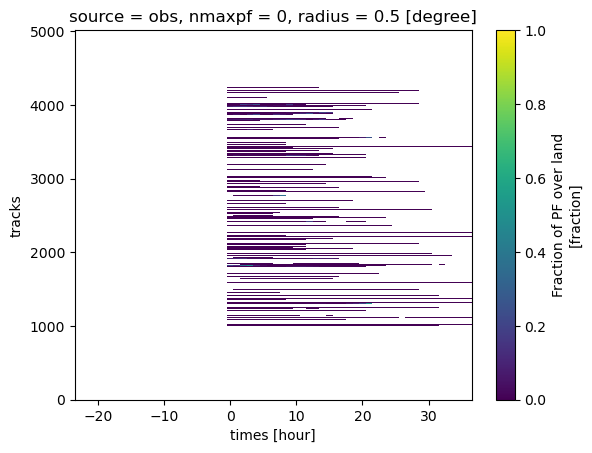

In [11]:
dss_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

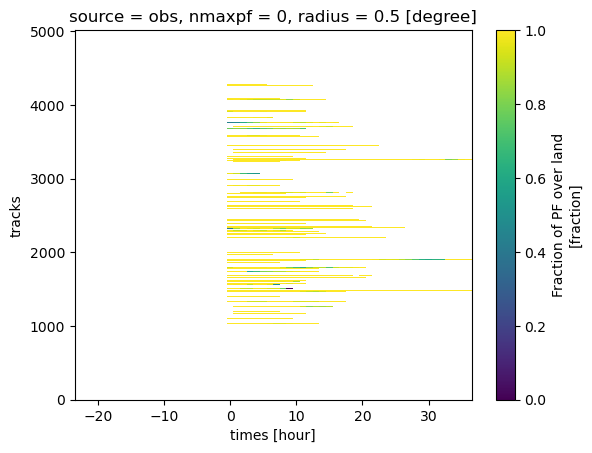

In [12]:
dss_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

# Composite environment time-series

## Use a simple method to separate possible merge/split tracks
### If max CCS area occur within the first x% of a tracks start time: split; or within last x% of a tracks end time: merge

In [13]:
# Set max area time fraction thresholds (if max area occur between these times, the track is retained)
max_timefrac_thresh = [0.1, 0.9]
# Artificial preCI sample (so preCI times will not be filtered)
ns_preCI = 1000
# Min number of sample after CI to keep the composite values
min_ns = 100
# Quantile values for composite
quantiles = [0.25, 0.5, 0.75]

In [14]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_o = dss_o.ccs_area.idxmax(dim='times', skipna=True) / dss_o.track_duration
maxccs_timefrac_l = dss_l.ccs_area.idxmax(dim='times', skipna=True) / dss_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_o = (dss_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_l = (dss_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_o = nsample_o.where(nsample_o.times > 0, other=ns_preCI)
nsample_l = nsample_l.where(nsample_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_o = dss_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_o > min_ns)).load()
intqv_avg_l = dss_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_l > min_ns)).load()
# intqv_pts_o = dss_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_o > min_ns)).load()
# intqv_pts_l = dss_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_l > min_ns)).load()

(array([ 582.,  973., 1051., 1303., 1536., 1402.,  778.,  717.,    0.]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 9 artists>)

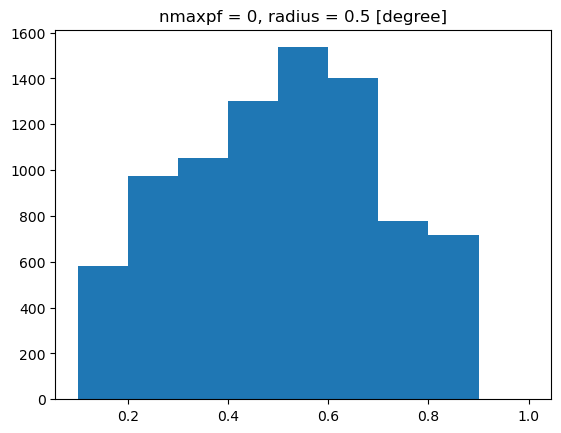

In [15]:
bins = np.arange(0.1, 1.01, 0.1)
maxccs_timefrac_o.where(mask_nonmergesplit_o).plot.hist(bins=bins)

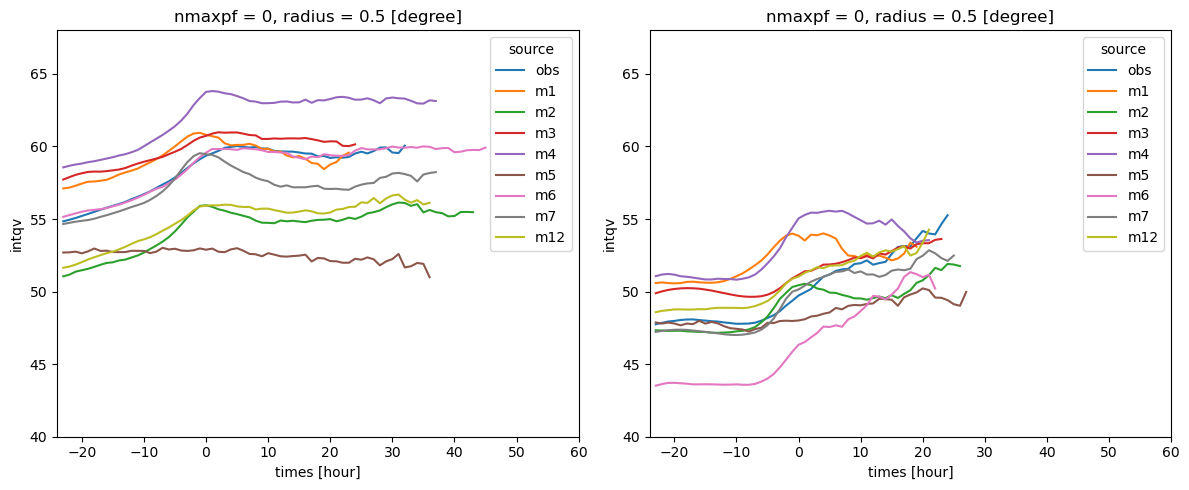

In [16]:
xlims = (-24, 60)
ylims = (40, 68)

nrows = 1
fig, axes = plt.subplots(nrows, 2, figsize=(12,5), dpi=100)
intqv_avg_o.plot.line(x='times', linestyle='-', ax=axes[0])
intqv_avg_l.plot.line(x='times', linestyle='-', ax=axes[1])

for row in range(nrows):
    for col in range(2):
        axes[col].set_xlim(xlims[0], xlims[1])
        axes[col].set_ylim(ylims[0], ylims[1])
fig.tight_layout()

# Function to plot time series for multiple trackers

In [17]:
def plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            # if row == 0:
            #     ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Share x-axis for all rows in each column
            if row < nrow - 1:
                # ax.get_xaxis().set_visible(False)
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlabels[col])
            
            # Plot data
            # for key, val in data_arr[row][col].items():
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xtime, idata, lcolors[key], lw=lws[key], label=legends[key])
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            # ax.set_xlabel(xlabels[row][col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks)
            if ylims is not None: ax.set_ylim(ylims[col][0], ylims[col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            # flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            # flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                xmin, xmax = ax.get_xlim()
                ax.axvspan(xmin, shade_dict['x'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.2), xytext=(0, -0.2), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

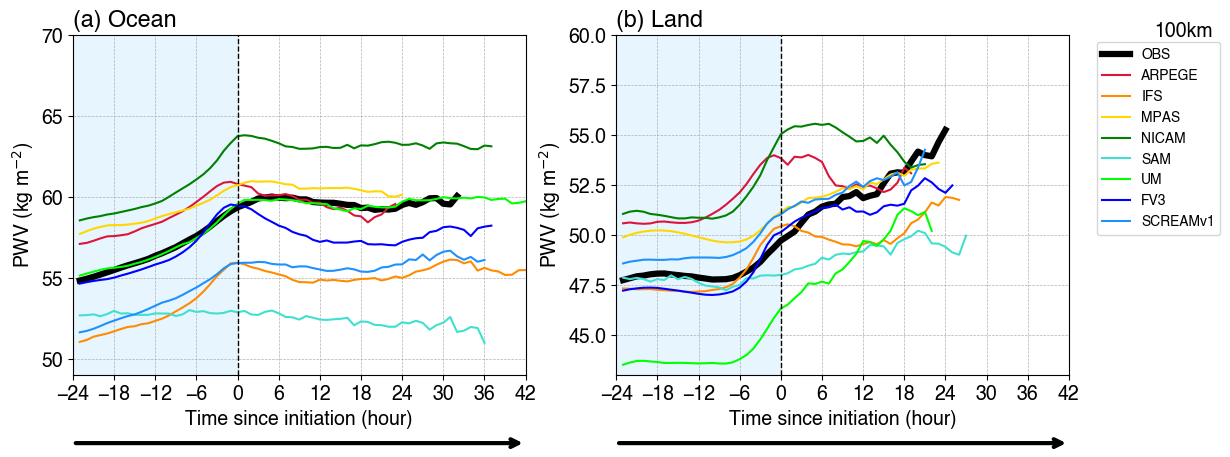

In [18]:
# Data array [row][col]
data_arr = [
    [intqv_avg_o, intqv_avg_l],
]
xtime = intqv_avg_o.times
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = ['', '']
titles = [
    ['(a) Ocean', '(b) Land',],
]
titles_loc = [0.97, 0.88]
title_ha = 'right'
xlabels = ['Time since initiation (hour)','Time since initiation (hour)']
ylabels = [['PWV (kg m$^{-2}$)', 'PWV (kg m$^{-2}$)']] * nrow
xticks = np.arange(-24, 42.1, 6)
xlims = [(-24,42),(-24,42)]
if (PHASE == 'Summer'): ylims = [(49,70),(43,60)]
if (PHASE == 'Winter'): ylims = [(49,64),(43,55)]
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.35, 1)
fontsize = 14
legend_fontsize = 10
figsize = [12,4]
wspace = 0.20
hspace = 0.05
text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.}
shade_dict = {'x':0, 'color':'lightskyblue', 'alpha':0.2}
figname = f'{figdir}mcs_pwv_composite_timeseries_ocean_land_{diameter_km:.0f}km.png'

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, draw_arrow=True, text_dict=text_dict, figname=figname, figsize=figsize)

In [20]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/PyFLEXTRKR/mcs_pwv_composite_timeseries_ocean_land_100km.png'

## Mask MCS variables for possible split/merge tracks

In [21]:
# Define preMCS time for sampling the environment
time_env = -1
dss_o.times

<xarray.DataArray 'times' (times: 124)>
array([-23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
        -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])
Coordinates:
  * times    (times) int64 -23 -22 -21 -20 -19 -18 -17 ... 94 95 96 97 98 99 100
    nmaxpf   int64 0
    radius   float64 0.5
Attributes:
    description:  Relative times for MCS lifecycle
    units:        hour

In [22]:
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_l < max(max_timefrac_thresh))

# Get preMCS environmental variable
intqv_preMCS_o = dss_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
intqv_preMCS_l = dss_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# MCS lifetime total rain volume [kg]
pfvolrain_o = dss_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
pfvolrain_l = dss_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# MCS lifetime max PF area
pfmaxarea_o = dss_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
pfmaxarea_l = dss_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# MCS lifetime max PF rain rate
pfmaxrr_o = dss_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
pfmaxrr_l = dss_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
pfmeanrr_o = dss_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
pfmeanrr_l = dss_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [23]:
lcolors = {
    'obs':'k', 
    'm1': 'crimson',
    'm2': 'darkorange', 
    'm3': 'gold',
    'm4': 'green',
    'm5': 'turquoise',
    'm6': 'lime',
    'm7': 'blue',
    'm8': 'deepskyblue',
    'm9': 'purple',
    'm10': 'violet',
    'm11': 'deeppink',
    'm12': 'dodgerblue',
}

Text(0.5, 1.0, 'Land')

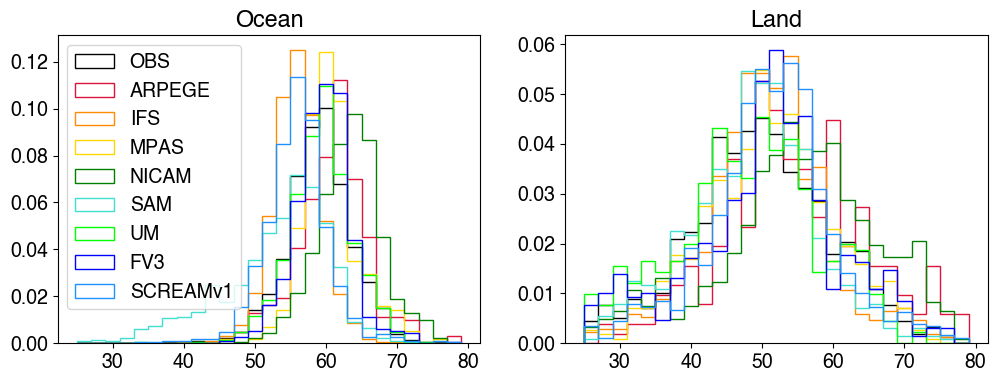

In [24]:
bins = np.arange(25, 81, 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
ax1 = axes[0]
ax2 = axes[1]
for source in intqv_preMCS_o['source'].data:
    # print(name_map[source])
    ax1.hist(intqv_preMCS_o.sel(source=source), bins=bins, histtype='step', label=f'{name_map[source]}', color=lcolors[source], density=True)
    ax2.hist(intqv_preMCS_l.sel(source=source), bins=bins, histtype='step', label=f'{name_map[source]}', color=lcolors[source], density=True)
ax1.legend()
ax1.set_title('Ocean')
ax2.set_title('Land')

## Function to convert DataArray to Pandas Dataframe
### Dataframe can be used with Seaborn for easier visualization

In [25]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

In [26]:
df_intqv_preMCS_o = dataarray_to_dataframe(intqv_preMCS_o.transpose(), column_names=name_map.values())
df_intqv_preMCS_l = dataarray_to_dataframe(intqv_preMCS_l.transpose(), column_names=name_map.values())

## Function to make box plots on multiple panels

In [27]:
def boxplot_mxn(nrow, ncol, data_arr, titles, xlabels, legends, figname,  
                col_labels=None, fontsize=fontsize, wspace=None, hspace=None, label_row=None, text_dict=None,
                legend_fontsize=11, legend_loc='best', legend_ncol=None, figsize=[10,10]):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    # fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)

    lcolors = {
        'obs': 'gray', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
    }
    lw = 1.5    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    pcolors = list(lcolors.values())[:data_arr[0][0].shape[1]]
    notch = False

    for col in range(0, ncol): 
        for row in range(0, nrow):
            # ax = axes[row][col]
            ax = plt.subplot(gs[row,col], sharex=ax if row > 0 else None)
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            # if row == 0:
            #     ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)
            
            # Label x-axis for the last row
            if row == nrow-1:
                ax.set_xlabel(xlabels[row][col])
            else:
                ax.tick_params(axis='x', labelbottom=False)
                
            sns.boxplot(data=data_arr[row][col], orient='h', ax=ax, palette=pcolors, showfliers=False, showmeans=True, 
                        width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
            ax.grid(axis='x', ls='--')
            ax.set_title(titles[row][col], loc='left')
            # if row == nrow-1: ax.set_xlabel(xlabels[row][col])
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            # if panel_colors is not None:
            #     ax.set_facecolor(panel_colors)
            # # Label yaxis, legend
            # if (col == 0):
            #     ax.text(-0.3, 0.5, label_row[row], va='center', ha='center', rotation=90, weight='bold', transform=ax.transAxes)

    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])
        
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

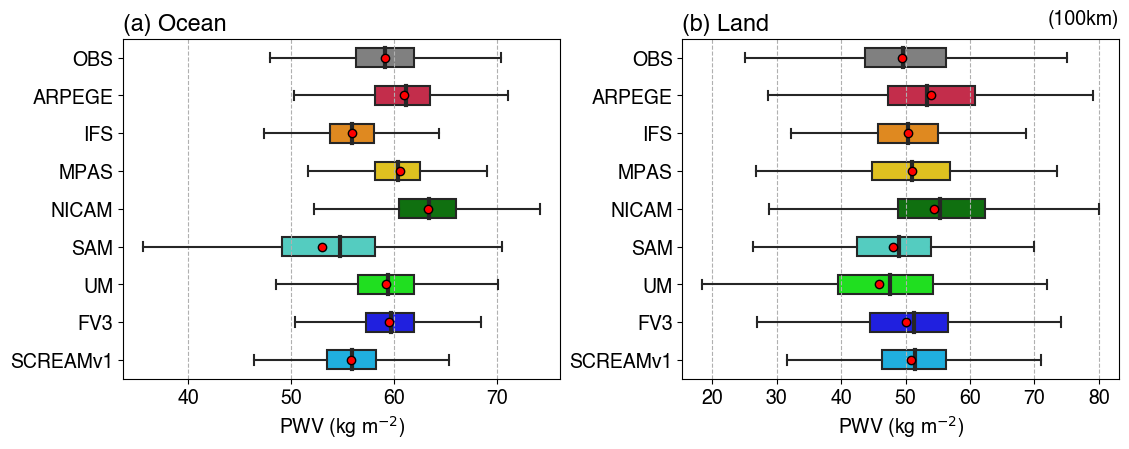

In [28]:
# col_labels = ['', '']
data_arr = [
    [df_intqv_preMCS_o, df_intqv_preMCS_l,],
]
nrow = len(data_arr)
titles = [
    ['(a) Ocean', '(b) Land',],
]
xlabels = [['PWV (kg m$^{-2}$)','PWV (kg m$^{-2}$)']]*nrow
legend_ncol = 1
fontsize = 14
wspace = 0.28
hspace = 0.05
figsize = [12,4]
text_dict = {'text': f'({diameter_km:.0f}km)', 'x': 0.88, 'y':1, 'ha':'right', 'va':'center', 'fontsize':fontsize*1}
figname = f'{figdir}boxplot_preMCS_pwv_ocean_land_{diameter_km:.0f}km.png'
# figname

fig = boxplot_mxn(nrow, 2, data_arr, titles, xlabels, legends, figname,
                  fontsize=fontsize, wspace=wspace, hspace=hspace, 
                  text_dict=text_dict, legend_fontsize=8, legend_loc='best', legend_ncol=legend_ncol, figsize=figsize)

In [30]:
# Define the desired number of bins
num_bins = 5

# Get all valid values of intqv from all sources
tmp = intqv_preMCS_o.values.flatten()
tmp = tmp[~np.isnan(tmp)]
# Compute bin edges to have roughly equal sample size in each bin
intqv_bins = np.percentile(tmp, np.linspace(0, 100, num_bins + 1))
intqv_bins_c = intqv_bins[:-1] + (intqv_bins[1:] - intqv_bins[:-1])/2
print(intqv_bins)
print(intqv_bins_c)

[22.65334129 54.26158905 57.18637238 59.69635239 62.72085953 84.00147247]
[38.45746517 55.72398071 58.44136238 61.20860596 73.361166  ]


## Count number of samples for each PWV bin for each source

In [31]:
nsource = len(name_map)
nbins = len(intqv_bins)-1
ns_o = np.full((nsource, nbins), np.NaN, dtype=float)
ns_l = np.full((nsource, nbins), np.NaN, dtype=float)

for ii, key in enumerate(name_map):
    print(ii, key)
    ns_o[ii,:] = pfvolrain_o.sel(source=key).groupby_bins(intqv_preMCS_o.sel(source=key), bins=intqv_bins).count().values
    ns_l[ii,:] = pfvolrain_l.sel(source=key).groupby_bins(intqv_preMCS_l.sel(source=key), bins=intqv_bins).count().values
    
# Convert to DataArray
ns_o = xr.DataArray(ns_o, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
ns_l = xr.DataArray(ns_l, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

0 obs
1 m1
2 m2
3 m3
4 m4
5 m5
6 m6
7 m7
8 m12


## Calculate mean MCS property groupby PWV for each source

In [32]:
nsource = len(name_map)
nbins = len(intqv_bins)-1
pfvolrain_avg_o = np.full((nsource, nbins), np.NaN, dtype=float)
pfvolrain_avg_l = np.full((nsource, nbins), np.NaN, dtype=float)

for ii, key in enumerate(name_map):
    print(ii, key)
    pfvolrain_avg_o[ii,:] = pfvolrain_o.sel(source=key).groupby_bins(intqv_preMCS_o.sel(source=key), bins=intqv_bins).mean().values
    pfvolrain_avg_l[ii,:] = pfvolrain_l.sel(source=key).groupby_bins(intqv_preMCS_l.sel(source=key), bins=intqv_bins).mean().values

# Convert to DataArray
pfvolrain_avg_o = xr.DataArray(pfvolrain_avg_o, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
pfvolrain_avg_l = xr.DataArray(pfvolrain_avg_l, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

0 obs
1 m1
2 m2
3 m3
4 m4
5 m5
6 m6
7 m7
8 m12


In [33]:
nsource = len(name_map)
nbins = len(intqv_bins)-1
pfmaxarea_avg_o = np.full((nsource, nbins), np.NaN, dtype=float)
pfmaxarea_avg_l = np.full((nsource, nbins), np.NaN, dtype=float)

for ii, key in enumerate(name_map):
    print(ii, key)
    pfmaxarea_avg_o[ii,:] = pfmaxarea_o.sel(source=key).groupby_bins(intqv_preMCS_o.sel(source=key), bins=intqv_bins).mean().values
    pfmaxarea_avg_l[ii,:] = pfmaxarea_l.sel(source=key).groupby_bins(intqv_preMCS_l.sel(source=key), bins=intqv_bins).mean().values

# Convert to DataArray
pfmaxarea_avg_o = xr.DataArray(pfmaxarea_avg_o, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
pfmaxarea_avg_l = xr.DataArray(pfmaxarea_avg_l, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

0 obs
1 m1
2 m2
3 m3
4 m4
5 m5
6 m6
7 m7
8 m12


In [34]:
nsource = len(name_map)
nbins = len(intqv_bins)-1
pfmaxrr_avg_o = np.full((nsource, nbins), np.NaN, dtype=float)
pfmaxrr_avg_l = np.full((nsource, nbins), np.NaN, dtype=float)

for ii, key in enumerate(name_map):
    print(ii, key)
    pfmaxrr_avg_o[ii,:] = pfmaxrr_o.sel(source=key).groupby_bins(intqv_preMCS_o.sel(source=key), bins=intqv_bins).mean().values
    pfmaxrr_avg_l[ii,:] = pfmaxrr_l.sel(source=key).groupby_bins(intqv_preMCS_l.sel(source=key), bins=intqv_bins).mean().values

# Convert to DataArray
pfmaxrr_avg_o = xr.DataArray(pfmaxrr_avg_o, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
pfmaxrr_avg_l = xr.DataArray(pfmaxrr_avg_l, coords={'source':ds.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

0 obs
1 m1
2 m2
3 m3
4 m4
5 m5
6 m6
7 m7
8 m12


## Filter bins with insufficient sample

In [35]:
# Min number of sample in each PWV bin
min_ns_thresh = 20

pfvolrain_avg_o = pfvolrain_avg_o.where(ns_o >= min_ns_thresh)
pfvolrain_avg_l = pfvolrain_avg_l.where(ns_l >= min_ns_thresh)

pfmaxarea_avg_o = pfmaxarea_avg_o.where(ns_o >= min_ns_thresh)
pfmaxarea_avg_l = pfmaxarea_avg_l.where(ns_l >= min_ns_thresh)

pfmaxrr_avg_o = pfmaxrr_avg_o.where(ns_o >= min_ns_thresh)
pfmaxrr_avg_l = pfmaxrr_avg_l.where(ns_l >= min_ns_thresh)

## Plot PF variables vs. PWV

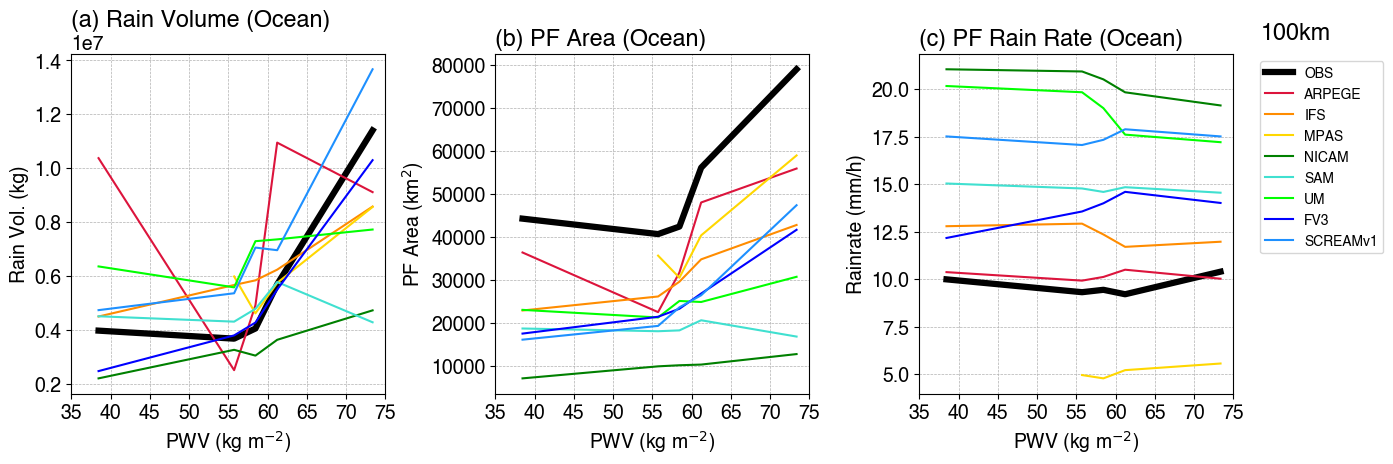

In [36]:
# Data array [row][col]
data_arr = [
    [pfvolrain_avg_o, pfmaxarea_avg_o, pfmaxrr_avg_o],
]
xtime = intqv_bins_c
legends = name_map
nrow = len(data_arr)
# col_labels = ['Rain Volume', 'PF Area', 'PF Rain Rate']
ncol = len(data_arr[0])
titles = [
    ['(a) Rain Volume (Ocean)', '(b) PF Area (Ocean)', '(c) PF Rain Rate (Ocean)'],
]
titles_loc = [0.04, 0.88]
title_ha = 'left'
xlabels = ['PWV (kg m$^{-2}$)'] * ncol
ylabels = [['Rain Vol. (kg)', 'PF Area (km$^2$)', 'Rainrate (mm/h)']] * nrow
xticks = np.arange(35,75.1,5)
xlims = [(35,75)] * ncol
ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.5, 1)
fontsize = 14
legend_fontsize = 10
figsize = [14,4]
figname = f'{figdir}mcs_pwv_binavg_ocean_all_{diameter_km:.0f}km.png'
wspace = 0.35
hspace = 0.1
text_dict = {'text': f'{diameter_km:.0f}km', 'x': 0.95, 'y':1, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.2}

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, wspace=wspace, hspace=hspace,
                   text_dict=text_dict, figname=figname, figsize=figsize)

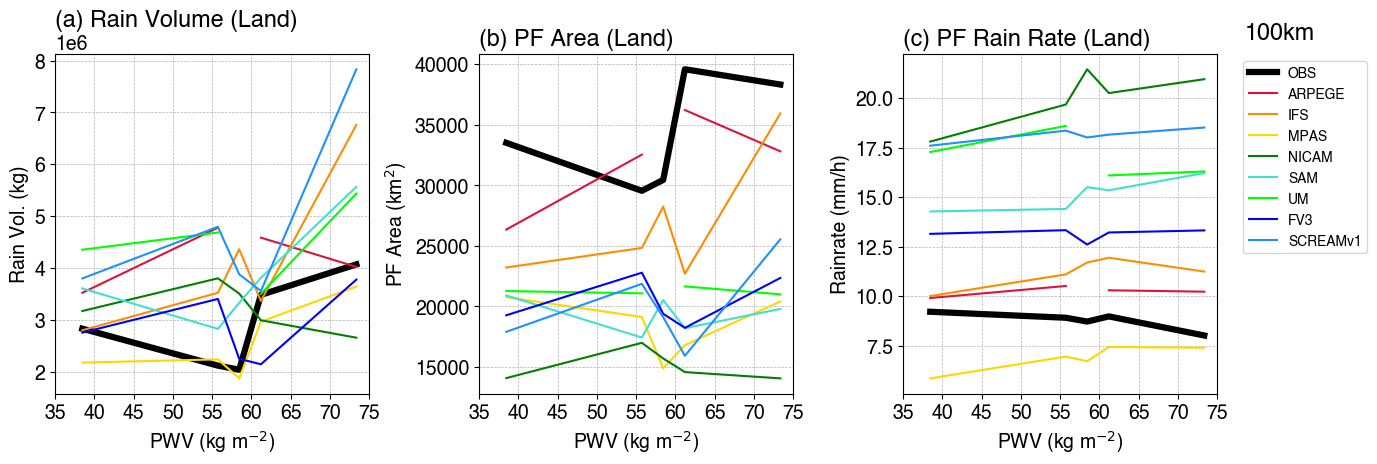

In [37]:
# Data array [row][col]
data_arr = [
    [pfvolrain_avg_l, pfmaxarea_avg_l, pfmaxrr_avg_l],
]
xtime = intqv_bins_c
legends = name_map
nrow = len(data_arr)
# col_labels = ['Rain Volume', 'PF Area', 'PF Rain Rate']
ncol = len(data_arr[0])
titles = [
    ['(a) Rain Volume (Land)', '(b) PF Area (Land)', '(c) PF Rain Rate (Land)'],
]
titles_loc = [0.04, 0.88]
title_ha = 'left'
xlabels = ['PWV (kg m$^{-2}$)'] * ncol
ylabels = [['Rain Vol. (kg)', 'PF Area (km$^2$)', 'Rainrate (mm/h)']] * nrow
xticks = np.arange(35,75.1,5)
xlims = [(35,75)] * ncol
ylims = None
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.5, 1)
fontsize = 14
legend_fontsize = 10
figsize = [14,4]
figname = f'{figdir}mcs_pwv_binavg_land_all_{diameter_km:.0f}km.png'
wspace = 0.35
hspace = 0.1
text_dict = {'text': f'{diameter_km:.0f}km', 'x': 0.95, 'y':1, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.2}

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, wspace=wspace, hspace=hspace,
                   text_dict=text_dict, figname=figname, figsize=figsize)

In [38]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/PyFLEXTRKR/mcs_pwv_binavg_land_all_100km.png'